In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2


In /home/hoangdzung/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/hoangdzung/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/hoangdzung/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/hoangdzung/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/hoangdzung/.local/lib/python3.6/site-packages/m

In [2]:
### just for testing the correctness
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from scipy.stats import pearsonr
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile, chi2,mutual_info_regression,mutual_info_classif
from collections import Counter
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold


## Load the training data into feature matrix, class labels, and event ids:

In [3]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../../../ML_course/projects/project1/data/train.csv' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [4]:
DATA_TEST_PATH = '../../../ML_course/projects/project1/data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [5]:
col2id={'DER_mass_MMC': 0,
 'DER_mass_transverse_met_lep': 1,
 'DER_mass_vis': 2,
 'DER_pt_h': 3,
 'DER_deltaeta_jet_jet': 4,
 'DER_mass_jet_jet': 5,
 'DER_prodeta_jet_jet': 6,
 'DER_deltar_tau_lep': 7,
 'DER_pt_tot': 8,
 'DER_sum_pt': 9,
 'DER_pt_ratio_lep_tau': 10,
 'DER_met_phi_centrality': 11,
 'DER_lep_eta_centrality': 12,
 'PRI_tau_pt': 13,
 'PRI_tau_eta': 14,
 'PRI_tau_phi': 15,
 'PRI_lep_pt': 16,
 'PRI_lep_eta': 17,
 'PRI_lep_phi': 18,
 'PRI_met': 19,
 'PRI_met_phi': 20,
 'PRI_met_sumet': 21,
 'PRI_jet_num': 22,
 'PRI_jet_leading_pt': 23,
 'PRI_jet_leading_eta': 24,
 'PRI_jet_leading_phi': 25,
 'PRI_jet_subleading_pt': 26,
 'PRI_jet_subleading_eta': 27,
 'PRI_jet_subleading_phi': 28,
 'PRI_jet_all_pt': 29}

## Do your thing crazy machine learning thing here :) ...

In [6]:
class Normalizer():
    def __init__(self):
        self.mean=None
        self.std=None
    def fit(self,tX):
        self.mean = np.mean(tX,0)
        self.std = np.std(tX,0)
        
    def transform(self,tX):  
        tX =(tX-self.mean)/(self.std+1e-20)
        return tX
    
    def fit_transform(self, tX):
        self.fit(tX)
        return self.transform(tX)

class Imputer():
    def __init__(self,missing_value=-999, dropnan=False,replacenan=None):
        assert type(missing_value)==int, "This version handles missing value in form of int only"
        self.missing_value = missing_value
        self.dropnan=dropnan
        self.replacenan=replacenan
        self.value = None
        
    def fit(self,tX):
        tX_ = tX.copy()
        self.notnan_cols = np.all(tX_!=self.missing_value,axis=0)
        if self.replacenan=='mean':
            tX_[tX_==self.missing_value]=np.nan
            self.value=np.nanmean(tX_,0)
        elif self.replacenan=='median':
            tX_[tX_==self.missing_value]=np.nan
            self.value=np.nanmedian(tX_,0)
        elif self.replacenan=='most_frequent':
            tX_[tX_==self.missing_value]=np.nan
            self.value=[]
            for i in range(tX_.shape[1]):
                tX_i = tX_[:,i]
                self.value.append(np.unique(tX_i[~np.isnan(tX_i)])[0])
            self.value=np.array(self.value)
        elif type(self.replacenan)==int:
            self.value=self.replacenan
        
    def transform(self,tX):
        if self.dropnan:
            tX=tX[:,self.notnan_cols]
        elif self.value is not None:
            inds = np.where(tX==-999)
            tX[inds] = np.take(self.value, inds[1])

        return tX
    
    def fit_transform(self, tX):
        self.fit(tX)
        return self.transform(tX)
    
class PolynomialFeature():
    def __init__(self,degree=1,cross_feat=False):
        self.degree=degree
        self.cross_feat = cross_feat
    
    def create_crossfeat(self, tX,degree):

        indices = [np.arange(tX.shape[1]) for i in range(degree)]
        combinations = np.array(np.meshgrid(*indices)).T.reshape(-1,degree)
        combinations=combinations[((combinations[:,1:]-combinations[:,:-1])>0).all(axis=1)]

        new_feats = []
        for combination in combinations:
            new_feats.append(np.prod(tX[ :,combination],axis=1,keepdims=True))

        return np.concatenate(new_feats,axis=1)

    def fit_transform(self,tX):
        if self.degree >1:
            tXs = [tX]
            for d in range(2,self.degree+1):
                tXs.append(tX**d)
            if self.cross_feat:
                tXs.append(self.create_crossfeat(tX,self.degree))
            tX = np.concatenate(tXs, axis=1)
        return tX

    def transform(self,tX):
        return self.fit_transform(tX)
    
class Pipeline():
    def __init__(self,*transformers):
        self.transformers = transformers
    def fit(self, tX):
        for transformer in self.transformers:
            tX = transformer.fit_transform(tX)
    def transform(self, tX,add_bias=True):
        for transformer in self.transformers:
            tX = transformer.transform(tX)
        if add_bias:
            tX = np.concatenate([tX,np.ones((tX.shape[0],1))], axis=1)
        return tX
    def fit_transform(self, tX,add_bias=True):
        for transformer in self.transformers:
            tX = transformer.fit_transform(tX)
        if add_bias:
            tX = np.concatenate([tX,np.ones((tX.shape[0],1))], axis=1)
        return tX

In [7]:
def build_k_indices(y, k_fold, seed=None):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    if seed is not None:
        np.random.seed(seed)
        indices = np.random.permutation(num_row)
    else:
        indices = np.arange(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)


In [8]:
def pred(x_test, w,threshold=0,neg_label=-1):
    logit_test = x_test@w

    logit_test[logit_test>=threshold]=1
    logit_test[logit_test<threshold]=neg_label

    return logit_test

In [9]:
def acc_score(actual, predicted):
    return (actual==predicted).mean()

def f1_score(actual, predicted, label=1):

    """ A helper function to calculate f1-score for the given `label` """

    # F1 = 2 * (precision * recall) / (precision + recall)
    tp = np.sum((actual==label) & (predicted==label))
    fp = np.sum((actual!=label) & (predicted==label))
    fn = np.sum((predicted!=label) & (actual==label))
    
    precision = tp/(tp+fp+1e-20)
    recall = tp/(tp+fn+1e-20)
    f1 = 2 * (precision * recall) / (precision + recall+1e-20)
    return f1

In [10]:
def remove_outliers(arr,y, k):
    mu, sigma = np.mean(arr, axis=0), np.std(arr, axis=0, ddof=1)
    keep_indices=np.all(np.abs((arr - mu) / (sigma+1e-20)) < k, axis=1)
    return arr[keep_indices], y[keep_indices]

In [11]:
features=[['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_met', 'PRI_met_sumet'],
         ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'PRI_tau_pt', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_met', 'PRI_met_phi', 'PRI_met_sumet', 'PRI_jet_leading_pt', 'PRI_jet_all_pt'],
         ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_lep_pt', 'PRI_met', 'PRI_met_sumet', 'PRI_jet_leading_pt', 'PRI_jet_subleading_pt', 'PRI_jet_all_pt'],
         ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_met', 'PRI_jet_subleading_pt', 'PRI_jet_all_pt']]

In [12]:
baseline_scaler = StandardScaler()
scaler = Normalizer()
test_X = np.random.randint(0,255, (200,200))
np.allclose(baseline_scaler.fit_transform(tX),scaler.fit_transform(tX))

True

In [13]:
for strategy in ["mean","median","most_frequent"]:
    baseline_imputer = SimpleImputer(missing_values=-999, strategy="mean")
    imputer = NanHandler(missing_value=-999, replacenan="mean")
    assert np.allclose(baseline_imputer.fit_transform(tX),imputer.fit_transform(tX))

In [14]:
X_test=np.random.randint(0,4,(5,3))
baseline_trans = PolynomialFeatures(degree=2)
trans = PolynomialFeature(degree=2,cross_feat=True)
print(baseline_trans.fit_transform(X_test))
print(trans.transform(X_test))

[[1. 0. 1. 2. 0. 0. 0. 1. 2. 4.]
 [1. 3. 0. 2. 9. 0. 6. 0. 0. 4.]
 [1. 0. 2. 3. 0. 0. 0. 4. 6. 9.]
 [1. 2. 0. 0. 4. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 1. 0. 0.]]
[[0 1 2 0 1 4 0 0 2]
 [3 0 2 9 0 4 0 6 0]
 [0 2 3 0 4 9 0 0 6]
 [2 0 0 4 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0]]


In [15]:
from implementations import *

In [16]:
k_fold=5
seed=1

In [17]:
k_indices = build_k_indices(y, k_fold, seed=None)

In [18]:
for model in [logistic_regression]:
    acc_trains, acc_tests = [], []
    f1_trains, f1_tests = [], []
    for k in range(k_fold):
#     kf = KFold(n_splits=5)
#     for train_indices, test_indices in kf.split(tX):
        train_indices = np.concatenate([k_indices[i] for i in range(k_indices.shape[0]) if i!=k])
        test_indices = k_indices[k]
        x_train, x_test = tX[train_indices], tX[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]
        y_train_preds, y_test_preds = [],[]
        y_train_sample = []
        y_test_sample = []
        for i in range(4):
            sub_x_train = x_train[x_train[:,col2id['PRI_jet_num']]==i][:,[col2id[col] for col in features[i]]]
            sub_y_train = y_train[x_train[:,col2id['PRI_jet_num']]==i]
            sub_x_test = x_test[x_test[:,col2id['PRI_jet_num']]==i][:,[col2id[col] for col in features[i]]]
            sub_y_test = y_test[x_test[:,col2id['PRI_jet_num']]==i]

            sub_x_train, sub_y_train = remove_outliers(sub_x_train, sub_y_train, 3)
            pipeline=Pipeline(NanHandler(missing_value=-999, replacenan='most_frequent'),PolynomialFeature(degree=3),Normalizer())
    #             pipeline = make_pipeline(SimpleImputer(missing_values=-999, strategy='most_frequent'),
    #                             PolynomialFeatures(3),
    #                             StandardScaler())            
            sub_x_train = pipeline.fit_transform(sub_x_train)
            sub_x_test = pipeline.transform(sub_x_test)

            w,loss = model(sub_y_train, sub_x_train, lambda_=1, initial_w=np.ones(sub_x_train.shape[1]),max_iters=1000,gamma=0.05,check_every=1,tol=1e-10)
    #         model=LogisticRegression()
    #         model.fit(sub_x_train,sub_y_train)
    #         sub_y_train_pred = model.predict(sub_x_train)
    #         sub_y_test_pred = model.predict(sub_x_test)
            sub_y_train_pred = pred(sub_x_train, w)
            sub_y_test_pred = pred(sub_x_test, w)

            y_train_preds.append(sub_y_train_pred)
            y_test_preds.append(sub_y_test_pred)
            y_train_sample.append(sub_y_train)
            y_test_sample.append(sub_y_test)
        y_train_pred = np.concatenate(y_train_preds)
        y_test_pred = np.concatenate(y_test_preds)
        y_train = np.concatenate(y_train_sample)
        y_test = np.concatenate(y_test_sample)
        acc_trains.append(acc_score(y_train, y_train_pred))
        acc_tests.append(acc_score(y_test, y_test_pred))
        f1_trains.append(f1_score(y_train, y_train_pred))
        f1_tests.append(f1_score(y_test, y_test_pred))
    print("{}±{} {}±{}".format(np.mean(acc_trains), np.std(acc_trains), np.mean(acc_tests), np.std(acc_tests)))    
    print("{}±{} {}±{}".format(np.mean(f1_trains), np.std(f1_trains), np.mean(f1_tests), np.std(f1_tests)))

100%|██████████| 1000/1000 [00:03<00:00, 255.20it/s]


0.8032690438045303±0.00030123119274009694 0.8027839999999999±0.0013460698347411311
0.6947291449245923±0.0008096800549601594 0.6925799762103847±0.003069634211115555


 31%|███       | 311/1000 [00:01<00:02, 263.06it/s]

0.7407325410818195±0.00021003925492129813 0.733096±0.001652121060939549
0.6549032250731277±0.000525742574839317 0.6506524711629709±0.002302020304141581


In [19]:
for model in [reg_logistic_regression]:
    acc_trains, acc_tests = [], []
    f1_trains, f1_tests = [], []
    for k in range(k_fold):
#     kf = KFold(n_splits=5)
#     for train_indices, test_indices in kf.split(tX):
        train_indices = np.concatenate([k_indices[i] for i in range(k_indices.shape[0]) if i!=k])
        test_indices = k_indices[k]
        x_train, x_test = tX[train_indices], tX[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]
        y_train_preds, y_test_preds = [],[]
        y_train_sample = []
        y_test_sample = []
        for i in range(4):
            sub_x_train = x_train[x_train[:,col2id['PRI_jet_num']]==i][:,[col2id[col] for col in features[i]]]
            sub_y_train = y_train[x_train[:,col2id['PRI_jet_num']]==i]
            sub_x_test = x_test[x_test[:,col2id['PRI_jet_num']]==i][:,[col2id[col] for col in features[i]]]
            sub_y_test = y_test[x_test[:,col2id['PRI_jet_num']]==i]

            sub_x_train, sub_y_train = remove_outliers(sub_x_train, sub_y_train, 3)
            pipeline=Pipeline(NanHandler(missing_value=-999, replacenan='most_frequent'),PolynomialFeature(degree=3),Normalizer())
    #             pipeline = make_pipeline(SimpleImputer(missing_values=-999, strategy='most_frequent'),
    #                             PolynomialFeatures(3),
    #                             StandardScaler())            
            sub_x_train = pipeline.fit_transform(sub_x_train)
            sub_x_test = pipeline.transform(sub_x_test)

            w,loss = model(sub_y_train, sub_x_train, lambda_=0.1, initial_w=np.ones(sub_x_train.shape[1]),max_iters=1000,gamma=0.05,check_every=-1,tol=1e-10)
    #         model=LogisticRegression()
    #         model.fit(sub_x_train,sub_y_train)
    #         sub_y_train_pred = model.predict(sub_x_train)
    #         sub_y_test_pred = model.predict(sub_x_test)
            sub_y_train_pred = pred(sub_x_train, w)
            sub_y_test_pred = pred(sub_x_test, w)

            y_train_preds.append(sub_y_train_pred)
            y_test_preds.append(sub_y_test_pred)
            y_train_sample.append(sub_y_train)
            y_test_sample.append(sub_y_test)
        y_train_pred = np.concatenate(y_train_preds)
        y_test_pred = np.concatenate(y_test_preds)
        y_train = np.concatenate(y_train_sample)
        y_test = np.concatenate(y_test_sample)
        acc_trains.append(acc_score(y_train, y_train_pred))
        acc_tests.append(acc_score(y_test, y_test_pred))
        f1_trains.append(f1_score(y_train, y_train_pred))
        f1_tests.append(f1_score(y_test, y_test_pred))
    print("{}±{} {}±{}".format(np.mean(acc_trains), np.std(acc_trains), np.mean(acc_tests), np.std(acc_tests)))    
    print("{}±{} {}±{}".format(np.mean(f1_trains), np.std(f1_trains), np.mean(f1_tests), np.std(f1_tests)))

100%|██████████| 1000/1000 [00:01<00:00, 916.85it/s]

0.7835801677894692±0.0005785420808911072 0.782364±0.0014973256158898767
0.676708533968245±0.0011788341203895119 0.6770442789091861±0.0031283120213172065


In [63]:
y_pred=[]
indices=[]
for i in range(4):
    sub_x_train = tX[tX[:,col2id['PRI_jet_num']]==i][:,[col2id[col] for col in features[i]]]
    sub_y_train = y[tX[:,col2id['PRI_jet_num']]==i]
    sub_x_test = tX_test[tX_test[:,col2id['PRI_jet_num']]==i][:,[col2id[col] for col in features[i]]]

    sub_x_train, sub_y_train = remove_outliers(sub_x_train, sub_y_train, 3)
    pipeline=Pipeline(NanHandler(missing_value=-999, replacenan='most_frequent'),PolynomialFeature(degree=3),Normalizer())
          
    sub_x_train = pipeline.fit_transform(sub_x_train)
    sub_x_test = pipeline.transform(sub_x_test)

    w,loss = logistic_regression(sub_y_train, sub_x_train, lambda_=1, initial_w=np.ones(sub_x_train.shape[1]),max_iters=1000,gamma=0.05,check_every=-1,tol=1e-10)
    y_pred.append(predict_labels(w, sub_x_test))
    indices.append(ids_test[tX_test[:,col2id['PRI_jet_num']]==i])
y_pred=np.concatenate(y_pred)
indices=np.concatenate(indices)

100%|██████████| 1000/1000 [00:02<00:00, 461.01it/s]


In [19]:
for model in [logistic_regression]:
    acc_trains, acc_tests = [], []
    f1_trains, f1_tests = [], []
    for k in range(k_fold):
#     kf = KFold(n_splits=5)
#     for train_indices, test_indices in kf.split(tX):
        train_indices = np.concatenate([k_indices[i] for i in range(k_indices.shape[0]) if i!=k])
        test_indices = k_indices[k]
        x_train, x_test = tX[train_indices], tX[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]
        y_train_preds, y_test_preds = [],[]
        y_train_sample = []
        y_test_sample = []
        for i in range(4):
            sub_x_train = x_train[x_train[:,col2id['PRI_jet_num']]==i]\
                        [:,[i for i in range(x_train.shape[1]) if not (x_train==-999).all()]]
            sub_y_train = y_train[x_train[:,col2id['PRI_jet_num']]==i]
            sub_x_test = x_test[x_test[:,col2id['PRI_jet_num']]==i]\
                        [:,[i for i in range(x_train.shape[1]) if not (x_train==-999).all()]]
            sub_y_test = y_test[x_test[:,col2id['PRI_jet_num']]==i]

            sub_x_train, sub_y_train = remove_outliers(sub_x_train, sub_y_train, 3)
            pipeline=Pipeline(NanHandler(missing_value=-999, replacenan='most_frequent'),PolynomialFeature(degree=3),Normalizer())
    #             pipeline = make_pipeline(SimpleImputer(missing_values=-999, strategy='most_frequent'),
    #                             PolynomialFeatures(3),
    #                             StandardScaler())            
            sub_x_train = pipeline.fit_transform(sub_x_train)
            sub_x_test = pipeline.transform(sub_x_test)

            w,loss = model(sub_y_train, sub_x_train, lambda_=1, initial_w=np.ones(sub_x_train.shape[1]),max_iters=1000,gamma=0.05,check_every=1,tol=1e-10)
    #         model=LogisticRegression()
    #         model.fit(sub_x_train,sub_y_train)
    #         sub_y_train_pred = model.predict(sub_x_train)
    #         sub_y_test_pred = model.predict(sub_x_test)
            sub_y_train_pred = pred(sub_x_train, w)
            sub_y_test_pred = pred(sub_x_test, w)

            y_train_preds.append(sub_y_train_pred)
            y_test_preds.append(sub_y_test_pred)
            y_train_sample.append(sub_y_train)
            y_test_sample.append(sub_y_test)
        y_train_pred = np.concatenate(y_train_preds)
        y_test_pred = np.concatenate(y_test_preds)
        y_train = np.concatenate(y_train_sample)
        y_test = np.concatenate(y_test_sample)
        acc_trains.append(acc_score(y_train, y_train_pred))
        acc_tests.append(acc_score(y_test, y_test_pred))
        f1_trains.append(f1_score(y_train, y_train_pred))
        f1_tests.append(f1_score(y_test, y_test_pred))
    print("{}±{} {}±{}".format(np.mean(acc_trains), np.std(acc_trains), np.mean(acc_tests), np.std(acc_tests)))    
    print("{}±{} {}±{}".format(np.mean(f1_trains), np.std(f1_trains), np.mean(f1_tests), np.std(f1_tests)))

100%|██████████| 1000/1000 [00:04<00:00, 201.38it/s]

0.8056198016081133±0.0005238036961081666 0.8043759999999999±0.0018069820142989784
0.6990053773706836±0.0009748198836597934 0.6955399996576077±0.0036335502448840928


## Generate predictions and save ouput in csv format for submission:

In [64]:
OUTPUT_PATH = 'numpy2nd.csv' # TODO: fill in desired name of output file for submission
# y_pred = predict_labels(w, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [7]:
import scipy.stats as stats
import pandas as pd
df=pd.read_csv('../../../ML_course/projects/project1/data/train.csv')

MannwhitneyuResult(statistic=618955624.5, pvalue=0.0)


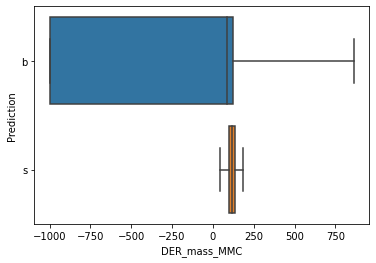

MannwhitneyuResult(statistic=383142894.5, pvalue=0.0)


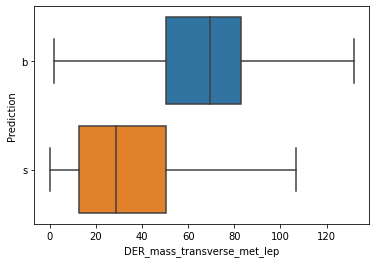

MannwhitneyuResult(statistic=742425068.5, pvalue=0.0)


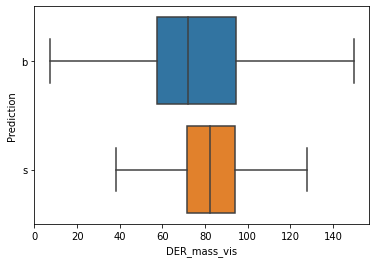

MannwhitneyuResult(statistic=927980816.5, pvalue=1.1067021161118768e-07)


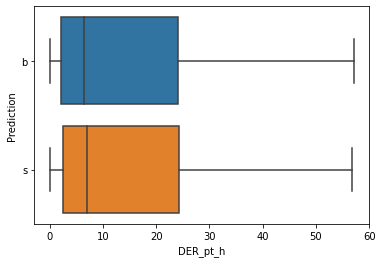

MannwhitneyuResult(statistic=627230763.0, pvalue=0.0)


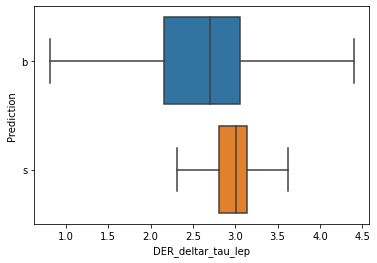

MannwhitneyuResult(statistic=927980833.5, pvalue=1.1067274952397279e-07)


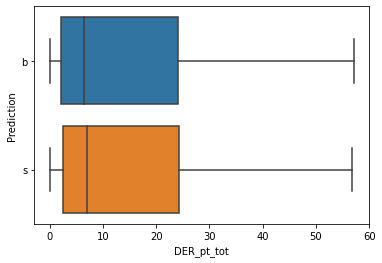

MannwhitneyuResult(statistic=709116130.0, pvalue=0.0)


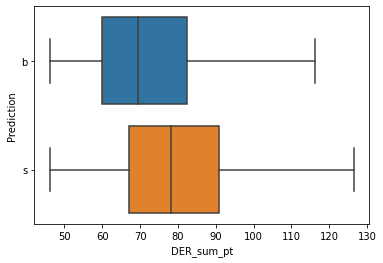

MannwhitneyuResult(statistic=475342030.0, pvalue=0.0)


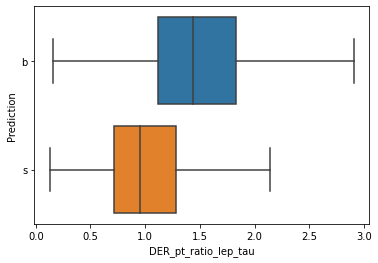

MannwhitneyuResult(statistic=929247693.5, pvalue=5.777222353256865e-07)


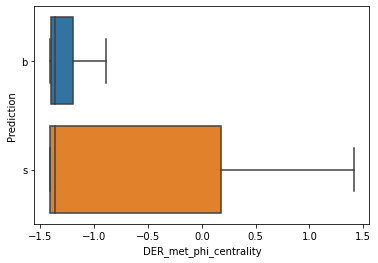

MannwhitneyuResult(statistic=491078760.5, pvalue=0.0)


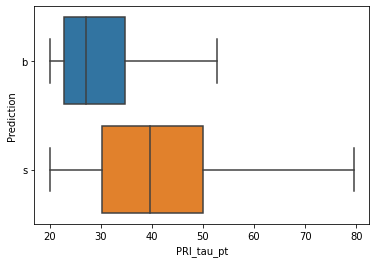

MannwhitneyuResult(statistic=939138729.5, pvalue=0.008821709574297818)


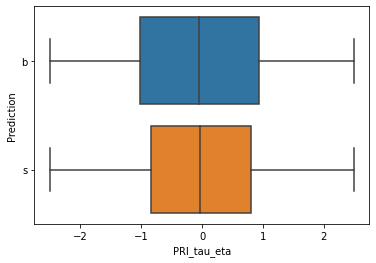

MannwhitneyuResult(statistic=941546227.0, pvalue=0.038591727685459716)


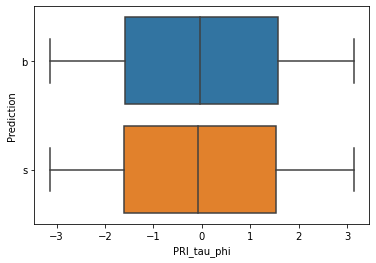

MannwhitneyuResult(statistic=782853010.0, pvalue=0.0)


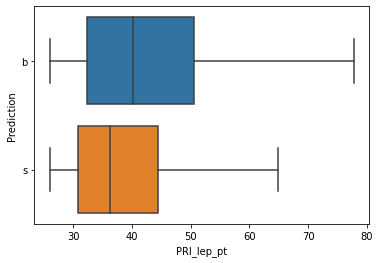

MannwhitneyuResult(statistic=927937266.0, pvalue=1.0434981670874263e-07)


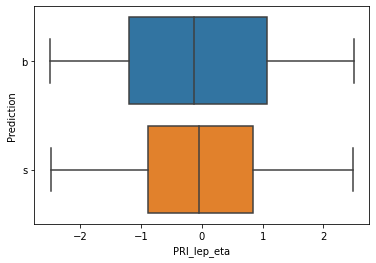

MannwhitneyuResult(statistic=943232276.0, pvalue=0.08962938760842681)


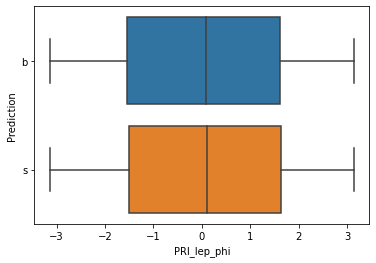

MannwhitneyuResult(statistic=515027637.5, pvalue=0.0)


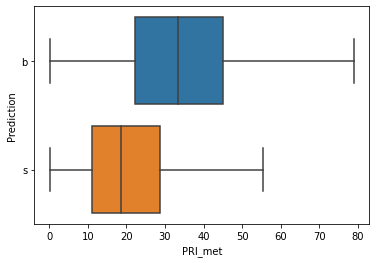

MannwhitneyuResult(statistic=947114548.0, pvalue=0.3570994769155539)


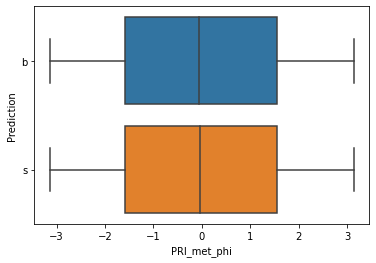

MannwhitneyuResult(statistic=807071094.5, pvalue=6.397837491462418e-278)


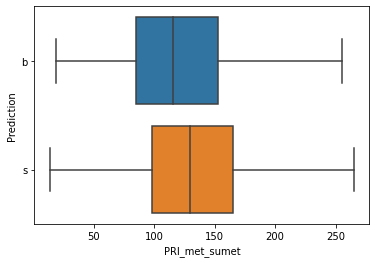

Error


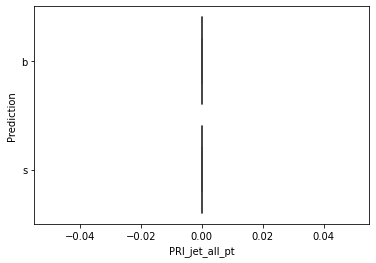

['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_met', 'PRI_met_sumet']


In [8]:
import seaborn as sns
df_=df[df['PRI_jet_num']==0]

features = [col for col in df_.columns if (df_[col]!=-999).any() and col not in ['Id','Prediction','PRI_jet_num']]
accepted_features = []
for col in features:
    if col in ['Id','Prediction','PRI_jet_num']:
        continue
    sns.boxplot(data=df_, x=col, y="Prediction",showfliers=False)
    try:
        r = stats.mannwhitneyu(df_[df_['Prediction']=='b'][col],df_[df_['Prediction']=='s'][col])
        print(r)
        if r.pvalue <0.01:
            accepted_features.append(col)
    except:
        print("Error")
    plt.show()
print(accepted_features)

MannwhitneyuResult(statistic=431288519.0, pvalue=0.0)


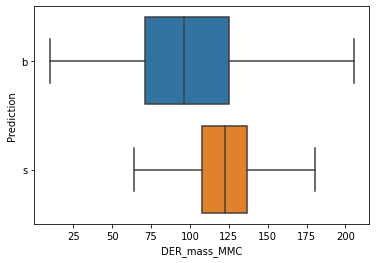

MannwhitneyuResult(statistic=420424385.0, pvalue=0.0)


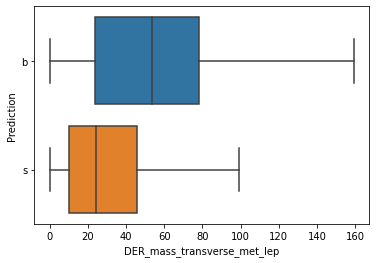

MannwhitneyuResult(statistic=564396009.0, pvalue=0.0)


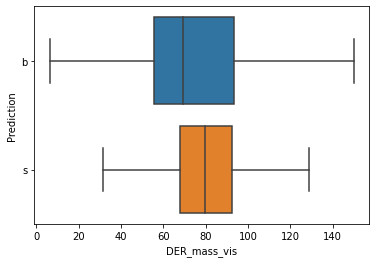

MannwhitneyuResult(statistic=561545702.0, pvalue=0.0)


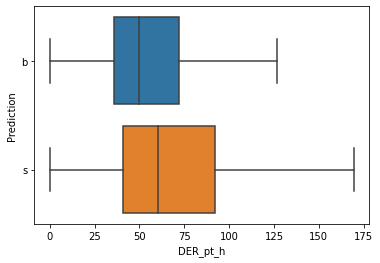

MannwhitneyuResult(statistic=663132900.5, pvalue=2.990445612764035e-20)


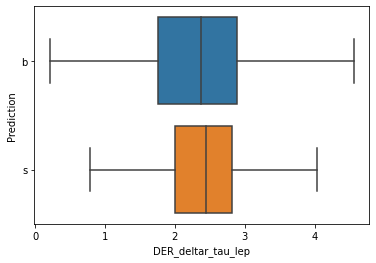

MannwhitneyuResult(statistic=654605996.5, pvalue=1.795144643743311e-33)


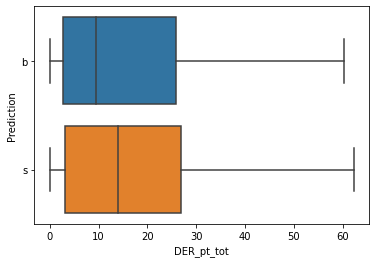

MannwhitneyuResult(statistic=519666240.5, pvalue=0.0)


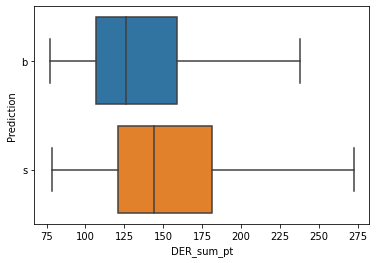

MannwhitneyuResult(statistic=495143373.5, pvalue=0.0)


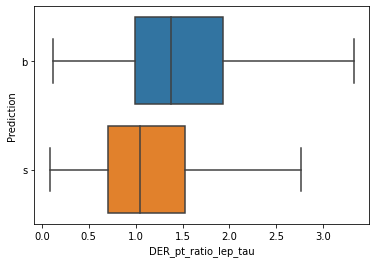

MannwhitneyuResult(statistic=486457292.5, pvalue=0.0)


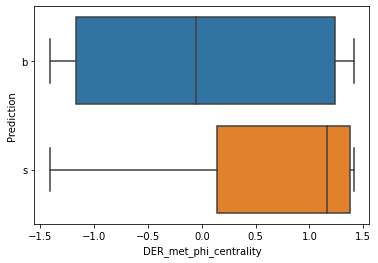

MannwhitneyuResult(statistic=455139282.0, pvalue=0.0)


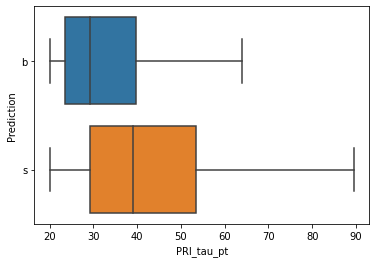

MannwhitneyuResult(statistic=686886588.5, pvalue=0.11645265110714154)


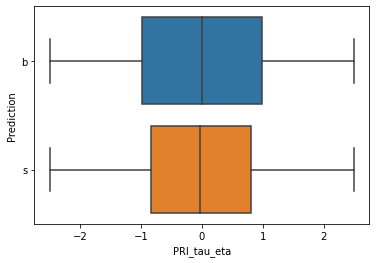

MannwhitneyuResult(statistic=684110006.0, pvalue=0.016902293559555862)


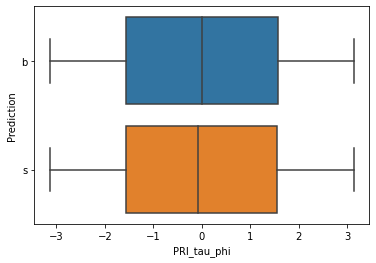

MannwhitneyuResult(statistic=650953287.5, pvalue=3.278728404844692e-40)


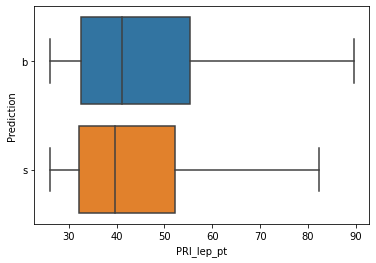

MannwhitneyuResult(statistic=681258251.0, pvalue=0.001045313925926486)


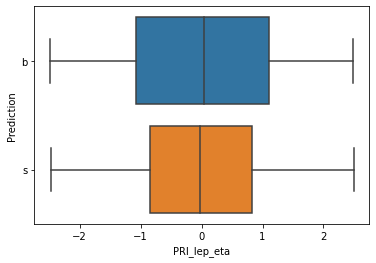

MannwhitneyuResult(statistic=687158277.5, pvalue=0.13524000082788545)


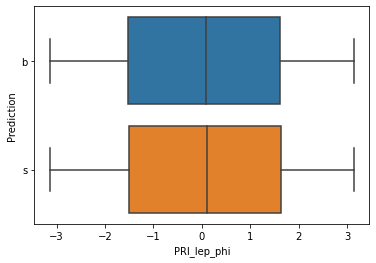

MannwhitneyuResult(statistic=673182712.0, pvalue=3.725991855554118e-09)


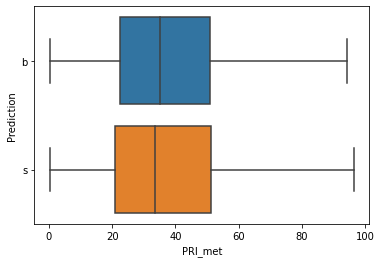

MannwhitneyuResult(statistic=682636192.5, pvalue=0.004451355888348563)


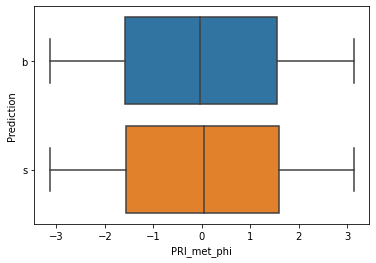

MannwhitneyuResult(statistic=574287014.0, pvalue=0.0)


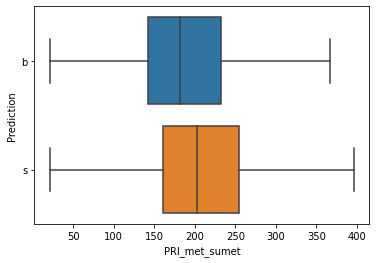

MannwhitneyuResult(statistic=549345910.0, pvalue=0.0)


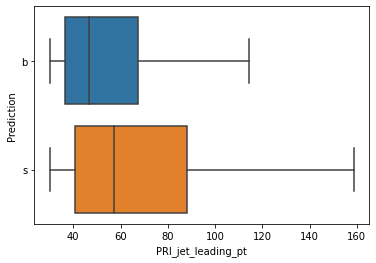

MannwhitneyuResult(statistic=687630629.0, pvalue=0.17262729232330232)


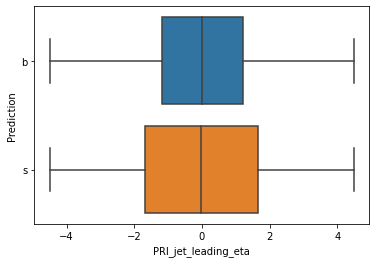

MannwhitneyuResult(statistic=688320771.5, pvalue=0.23798407814655143)


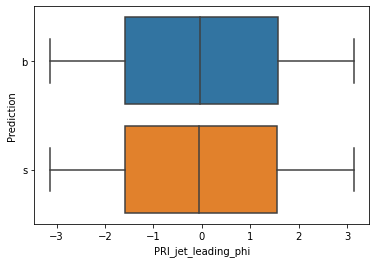

MannwhitneyuResult(statistic=549345908.5, pvalue=0.0)


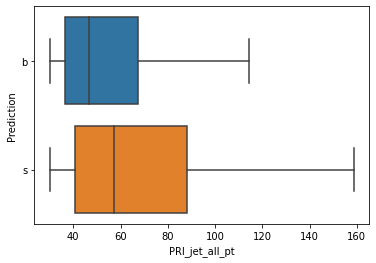

['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'PRI_tau_pt', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_met', 'PRI_met_phi', 'PRI_met_sumet', 'PRI_jet_leading_pt', 'PRI_jet_all_pt']


In [9]:
import seaborn as sns
df_=df[df['PRI_jet_num']==1]

features = [col for col in df_.columns if (df_[col]!=-999).any() and col not in ['Id','Prediction','PRI_jet_num']]
accepted_features = []
for col in features:
    if col in ['Id','Prediction','PRI_jet_num']:
        continue
    sns.boxplot(data=df_, x=col, y="Prediction",showfliers=False)
    try:
        r = stats.mannwhitneyu(df_[df_['Prediction']=='b'][col],df_[df_['Prediction']=='s'][col])
        print(r)
        if r.pvalue <0.01:
            accepted_features.append(col)
    except:
        print("Error")
    plt.show()
print(accepted_features)

MannwhitneyuResult(statistic=182327237.0, pvalue=0.0)


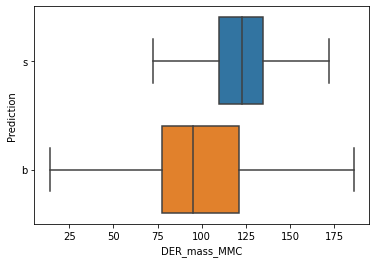

MannwhitneyuResult(statistic=216780612.0, pvalue=0.0)


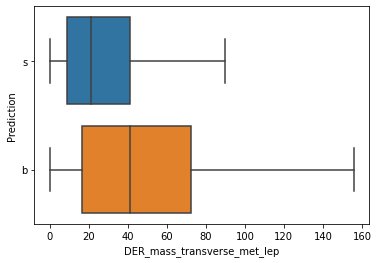

MannwhitneyuResult(statistic=255568753.5, pvalue=0.0)


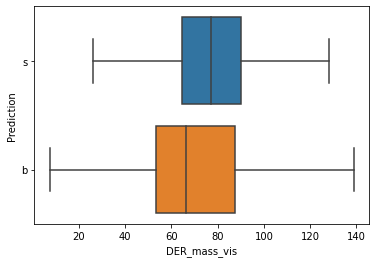

MannwhitneyuResult(statistic=250412773.5, pvalue=0.0)


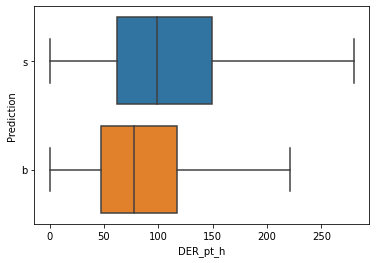

MannwhitneyuResult(statistic=191329285.5, pvalue=0.0)


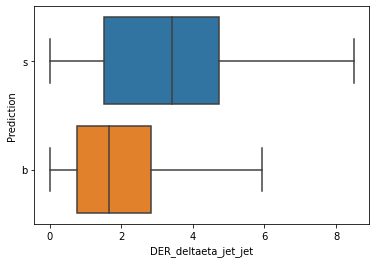

MannwhitneyuResult(statistic=191805821.5, pvalue=0.0)


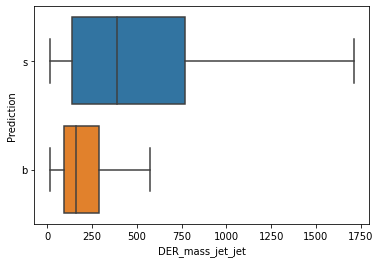

MannwhitneyuResult(statistic=195046342.5, pvalue=0.0)


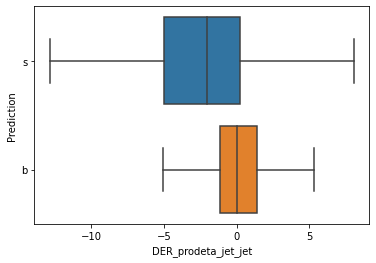

MannwhitneyuResult(statistic=307386402.0, pvalue=1.2825605324045853e-09)


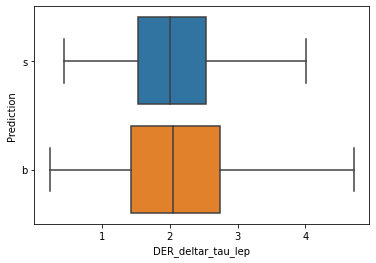

MannwhitneyuResult(statistic=252779352.0, pvalue=0.0)


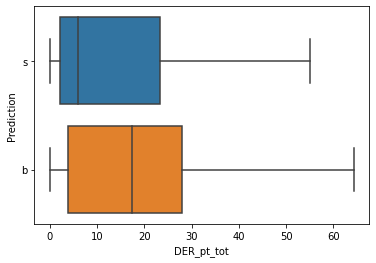

MannwhitneyuResult(statistic=257637985.5, pvalue=4.155282144778001e-291)


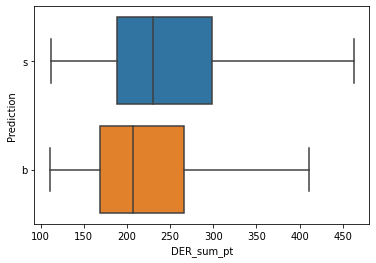

MannwhitneyuResult(statistic=247763945.5, pvalue=0.0)


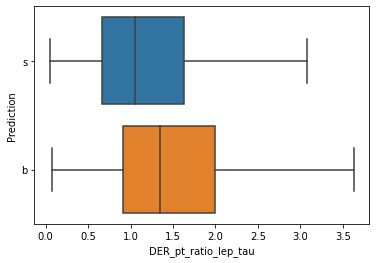

MannwhitneyuResult(statistic=227251144.5, pvalue=0.0)


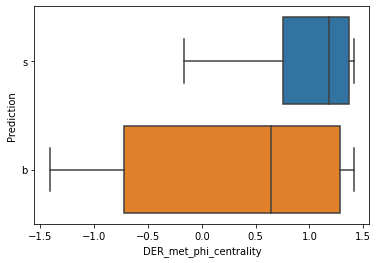

MannwhitneyuResult(statistic=195057062.0, pvalue=0.0)


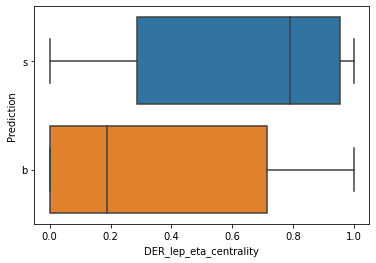

MannwhitneyuResult(statistic=227081977.0, pvalue=0.0)


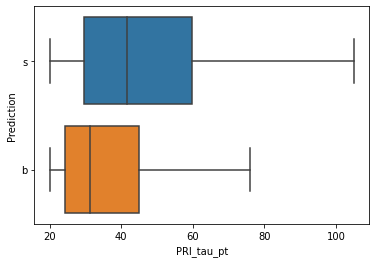

MannwhitneyuResult(statistic=313173292.5, pvalue=0.007957810996340216)


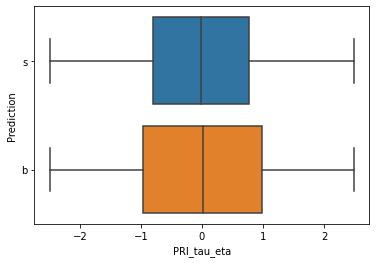

MannwhitneyuResult(statistic=315216711.0, pvalue=0.12331646056249707)


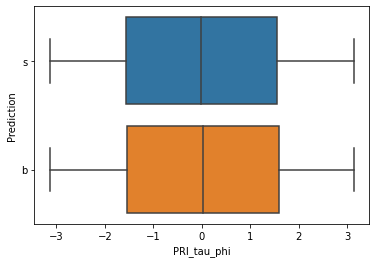

MannwhitneyuResult(statistic=310156231.0, pvalue=1.0230257017013195e-05)


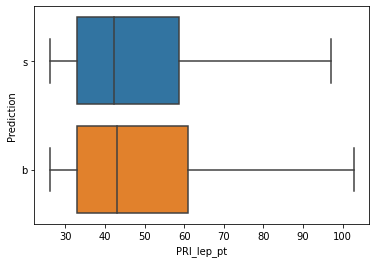

MannwhitneyuResult(statistic=313475934.5, pvalue=0.013028031993018826)


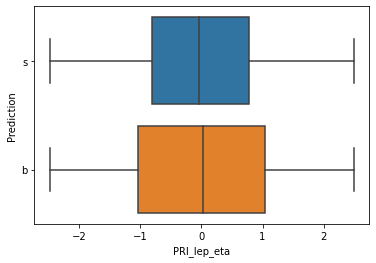

MannwhitneyuResult(statistic=316177996.5, pvalue=0.28452294747948537)


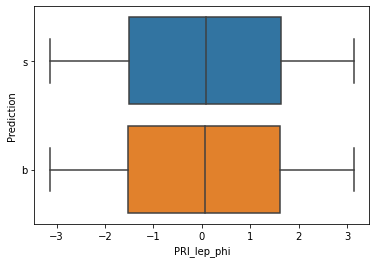

MannwhitneyuResult(statistic=295528332.5, pvalue=3.176642711077987e-40)


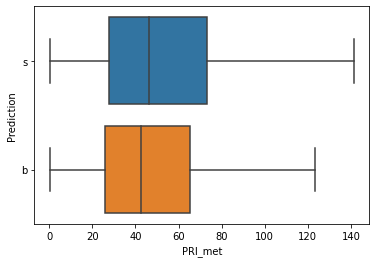

MannwhitneyuResult(statistic=313590553.0, pvalue=0.01557571801794915)


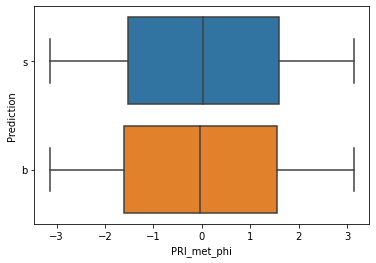

MannwhitneyuResult(statistic=299528014.0, pvalue=2.304841611935576e-27)


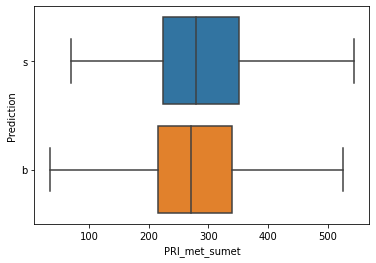

MannwhitneyuResult(statistic=266686699.0, pvalue=6.074569616430539e-210)


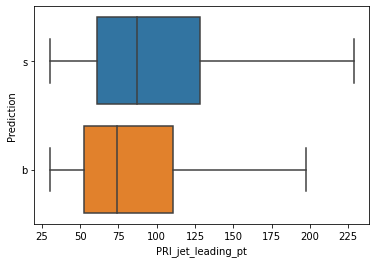

MannwhitneyuResult(statistic=314975947.5, pvalue=0.09575676085149265)


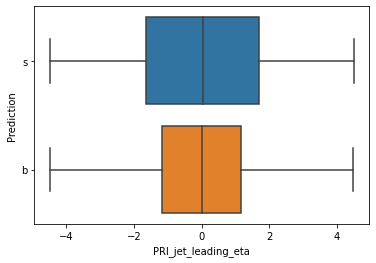

MannwhitneyuResult(statistic=315207409.0, pvalue=0.1221578898954429)


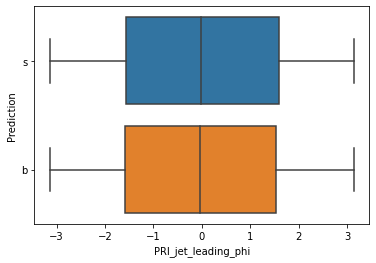

MannwhitneyuResult(statistic=268777586.5, pvalue=4.371318773879967e-193)


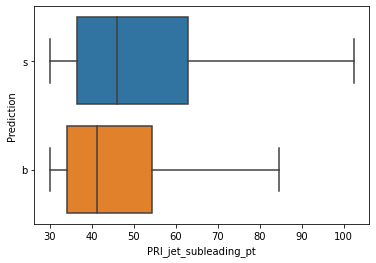

MannwhitneyuResult(statistic=316849276.0, pvalue=0.43719935667448195)


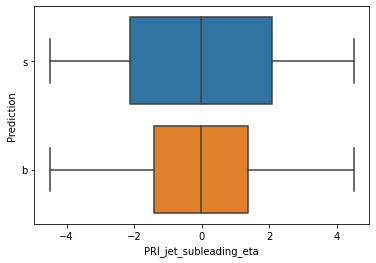

MannwhitneyuResult(statistic=313711721.0, pvalue=0.018722586679487254)


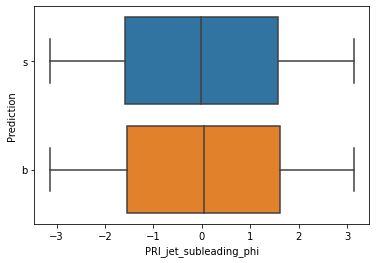

MannwhitneyuResult(statistic=262690944.0, pvalue=3.869268872162042e-244)


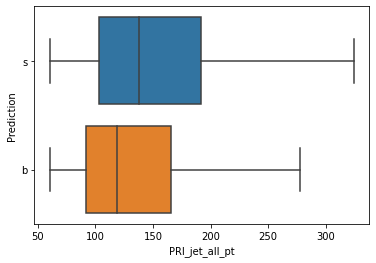

['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_lep_pt', 'PRI_met', 'PRI_met_sumet', 'PRI_jet_leading_pt', 'PRI_jet_subleading_pt', 'PRI_jet_all_pt']


In [10]:
import seaborn as sns
df_=df[df['PRI_jet_num']==2]

features = [col for col in df_.columns if (df_[col]!=-999).any() and col not in ['Id','Prediction','PRI_jet_num']]
accepted_features = []
for col in features:
    if col in ['Id','Prediction','PRI_jet_num']:
        continue
    sns.boxplot(data=df_, x=col, y="Prediction",showfliers=False)
    try:
        r = stats.mannwhitneyu(df_[df_['Prediction']=='b'][col],df_[df_['Prediction']=='s'][col])
        print(r)
        if r.pvalue <0.01:
            accepted_features.append(col)
    except:
        print("Error")
    plt.show()
print(accepted_features)

MannwhitneyuResult(statistic=30332525.0, pvalue=0.0)


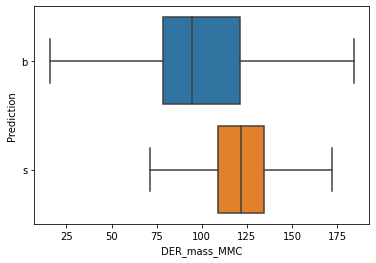

MannwhitneyuResult(statistic=38457151.5, pvalue=2.4422653839391087e-208)


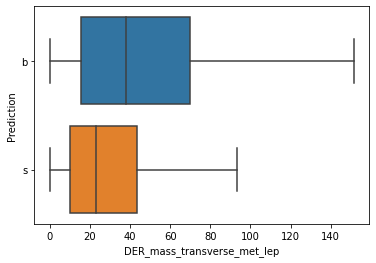

MannwhitneyuResult(statistic=43734264.5, pvalue=1.3439286639796462e-78)


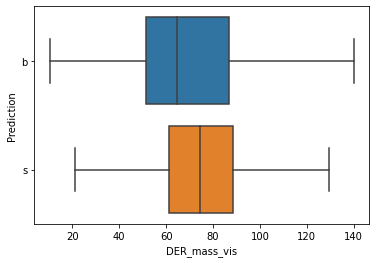

MannwhitneyuResult(statistic=40296880.5, pvalue=5.806941202663167e-156)


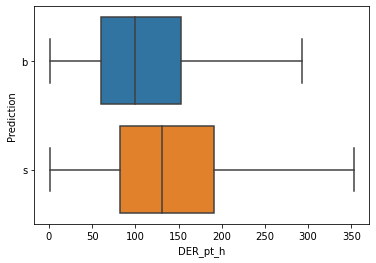

MannwhitneyuResult(statistic=46594983.0, pvalue=1.521414047568299e-34)


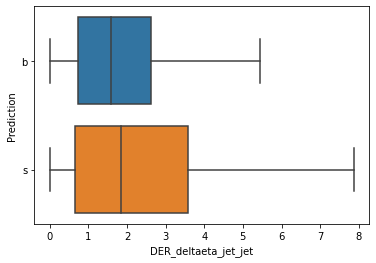

MannwhitneyuResult(statistic=49137404.0, pvalue=7.893306614789936e-11)


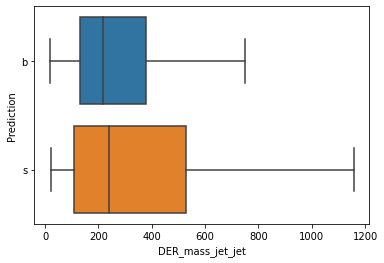

MannwhitneyuResult(statistic=46287264.0, pvalue=2.1302317171498194e-38)


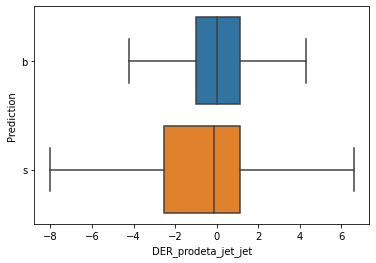

MannwhitneyuResult(statistic=48341450.5, pvalue=1.0636861646855303e-16)


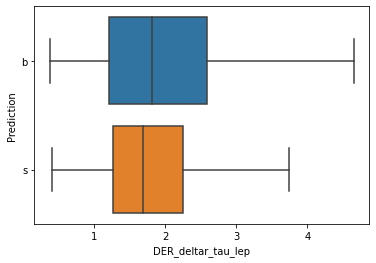

MannwhitneyuResult(statistic=48964787.5, pvalue=5.543160121512191e-12)


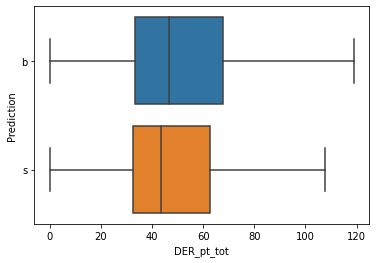

MannwhitneyuResult(statistic=51411276.5, pvalue=0.11381414054668648)


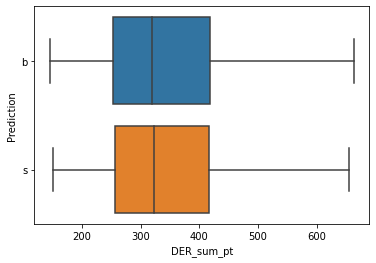

MannwhitneyuResult(statistic=42357437.5, pvalue=2.2116315228094636e-106)


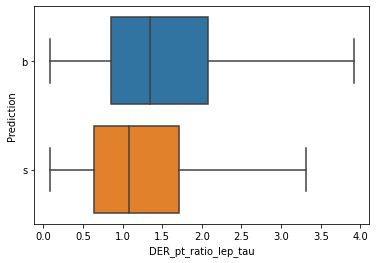

MannwhitneyuResult(statistic=39584938.5, pvalue=2.485813640614844e-175)


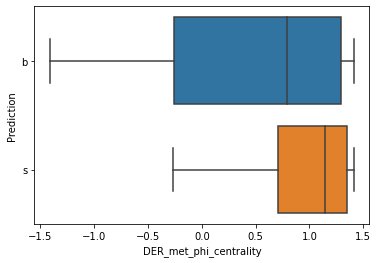

MannwhitneyuResult(statistic=44431355.5, pvalue=2.386929414226972e-67)


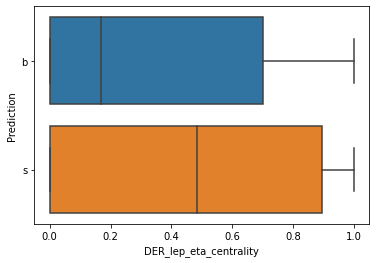

MannwhitneyuResult(statistic=39002505.0, pvalue=5.148172360805419e-192)


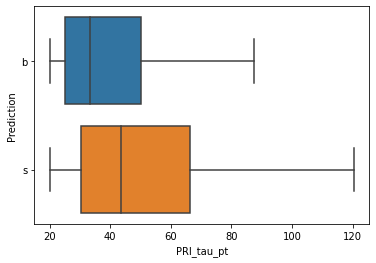

MannwhitneyuResult(statistic=50875522.5, pvalue=0.0075582152607037364)


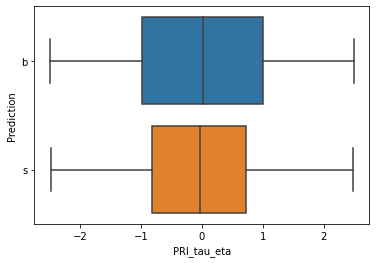

MannwhitneyuResult(statistic=51775727.0, pvalue=0.3540245662139656)


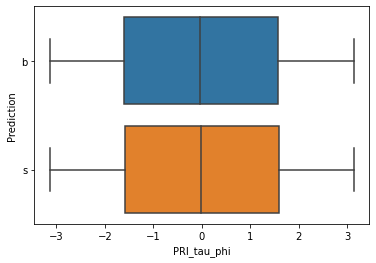

MannwhitneyuResult(statistic=51340839.0, pvalue=0.085766516471172)


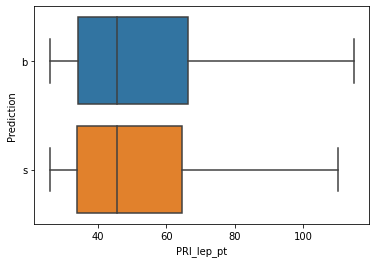

MannwhitneyuResult(statistic=51078981.0, pvalue=0.02470151230077101)


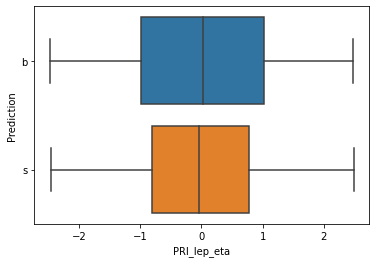

MannwhitneyuResult(statistic=51543496.5, pvalue=0.18282742138460634)


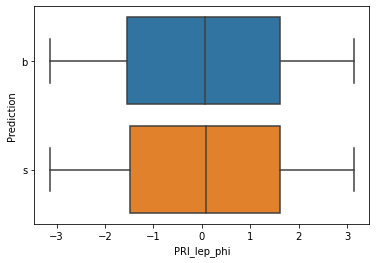

MannwhitneyuResult(statistic=46267096.0, pvalue=1.1706020954000652e-38)


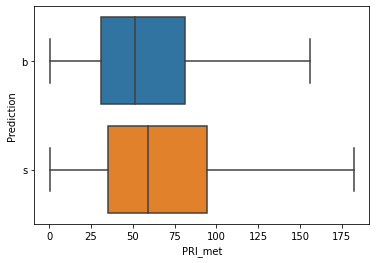

MannwhitneyuResult(statistic=51184870.0, pvalue=0.04241171059437987)


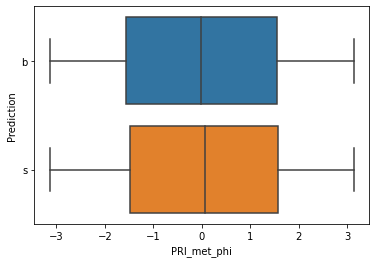

MannwhitneyuResult(statistic=51702981.5, pvalue=0.2944088904692309)


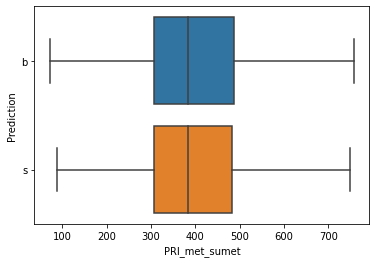

MannwhitneyuResult(statistic=51303385.0, pvalue=0.07313976521668417)


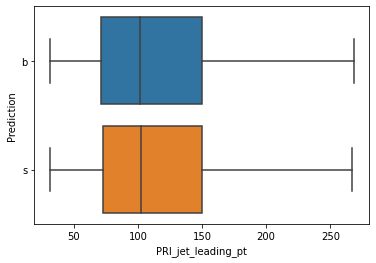

MannwhitneyuResult(statistic=51596349.0, pvalue=0.21652471674951568)


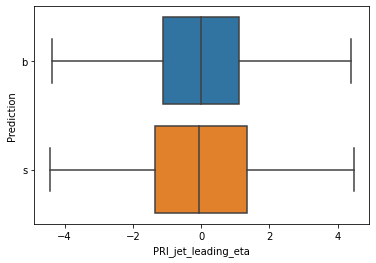

MannwhitneyuResult(statistic=51665123.5, pvalue=0.2653371465138874)


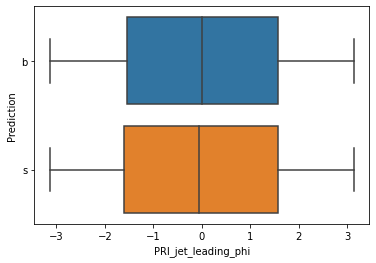

MannwhitneyuResult(statistic=50018897.0, pvalue=5.794233380161574e-06)


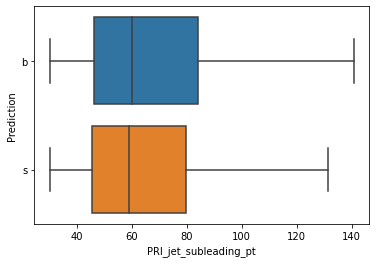

MannwhitneyuResult(statistic=51355977.5, pvalue=0.09130948987194237)


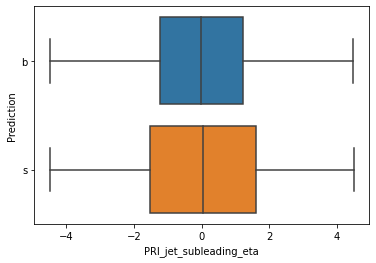

MannwhitneyuResult(statistic=51703287.5, pvalue=0.29464974128973875)


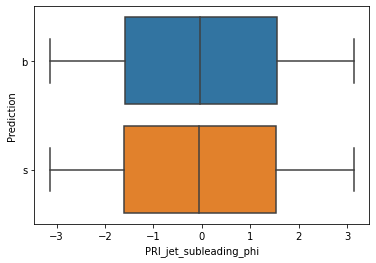

MannwhitneyuResult(statistic=50476346.5, pvalue=0.00041758669038369277)


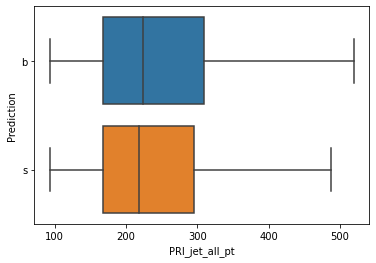

['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_met', 'PRI_jet_subleading_pt', 'PRI_jet_all_pt']


In [11]:
import seaborn as sns
df_=df[df['PRI_jet_num']==3]

features = [col for col in df_.columns if (df_[col]!=-999).any() and col not in ['Id','Prediction','PRI_jet_num']]
accepted_features = []
for col in features:
    if col in ['Id','Prediction','PRI_jet_num']:
        continue
    sns.boxplot(data=df_, x=col, y="Prediction",showfliers=False)
    try:
        r = stats.mannwhitneyu(df_[df_['Prediction']=='b'][col],df_[df_['Prediction']=='s'][col])
        print(r)
        if r.pvalue <0.01:
            accepted_features.append(col)
    except:
        print("Error")
    plt.show()
print(accepted_features)